# **Homework 2 - Name Entity Recognition (NER) task in zero-shot learning**
**Natural Language Processing** - a.a. 2024/25

Group members

Name         | Surname       | email                                  | ID number
-------------|---------------|----------------------------------------|---------
Francesco    | Chemello      | francesco.chemello.1@studenti.unipd.it | 2121346
Pietro       | Volpato       | pietro.volpato@studenti.unipd.it       | 2120825

Link to **GitHub repository** [here](https://github.com/FrancescoChemello/Natural-Language-Processing-Project/). 👈🏻


In [1]:
import os
import sys
import time
from tqdm import tqdm
import numpy as np

# Gemini libraries
from google import genai
from google.genai import types

In [2]:
# To manage environment variables
from google.colab import userdata

## **1 - Dataset**

In this section we introduce the dataset used for this homework: **CONLL-2003**.

### 1.1 - Dataset summary

The **CoNLL-2003** dataset is a pivotal resource in **Natural Language Processing**, specifically designed for the **Named Entity Recognition (NER)** task. Released as part of the CoNLL-2003 shared task on language-independent NER, it provides annotated text in both **English** (from the Reuters Corpus) and **German** (from the Frankfurter Rundschau newspaper).

The dataset organizes each word on a separate line, with sentences delineated by blank lines, and includes four key pieces of information per word: the word itself, its *Part-of-Speech* tag, a syntactic chunk tag, and its named entity tag. These named entities are categorized into **four** types:

- **ORGANIZATION (ORG)** - Organization entities such as *Georgia-Pacific Corp.*, *Apple*, or *Microsoft*.
- **PERSON (PER)** - People such as *Eddy Bonte*, *President Obama*, or *Paulo Dybala*.
- **LOCATION (LOC)** - Location entities such as *Murray River*, *Mount Everest*, or *Italy*.
- **MISCELLANEOUS (MISC)** - Miscellaneous entities such as *events*, *nationalities*, *products*, or *works of art*.

While the original dataset used the IOB1 tagging scheme, common versions (like those on [Hugging Face](https://huggingface.co/datasets/eriktks/conll2003)) often utilize the IOB2 scheme, where every new entity mention begins with a "B-" tag, making entity boundaries clearer. This structured format and comprehensive annotation have made CoNLL-2003 an enduring benchmark for evaluating and advancing NER models.

### 1.2 - Dataset availability and download

**CoNLL-2003** is readily available within `tensorflow_datasets` (TFDS), a convenient library that streamlines the process of accessing and preparing machine learning datasets for use with **TensorFlow** and other ML frameworks. By simply calling `tfds.load("conll2003")`, users can effortlessly download, parse, and obtain the dataset as `tf.data.Dataset` objects, automatically split into training, validation (dev), and test sets. This integration handles the underlying data structure, typically converting the raw text tokens and their associated *POS*, chunk, and *NER* tags into numerical representations suitable for model input, including the IOB2 scheme for named entity labels.

In [3]:
# To download the dataset
import tensorflow_datasets as tfds

In [4]:
# Download
ds, info = tfds.load("conll2003", split=['train', 'dev', 'test'], with_info=True)
train_ds, val_ds, test_ds = ds
print(info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/conll2003/conll2003/incomplete.ZBU1KA_1.0.0/conll2003-train.tfrecord*...: …

Generating dev examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/conll2003/conll2003/incomplete.ZBU1KA_1.0.0/conll2003-dev.tfrecord*...:   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/conll2003/conll2003/incomplete.ZBU1KA_1.0.0/conll2003-test.tfrecord*...:  …

Dataset conll2003 downloaded and prepared to /root/tensorflow_datasets/conll2003/conll2003/1.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='conll2003',
    full_name='conll2003/conll2003/1.0.0',
    description="""
    The shared task of CoNLL-2003 concerns language-independent named entity
    recognition and concentrates on four types of named entities: persons,
    locations, organizations and names of miscellaneous entities that do not belong
    to the previous three groups.
    """,
    homepage='https://www.aclweb.org/anthology/W03-0419/',
    data_dir='/root/tensorflow_datasets/conll2003/conll2003/1.0.0',
    file_format=tfrecord,
    download_size=959.94 KiB,
    dataset_size=3.87 MiB,
    features=FeaturesDict({
        'chunks': Sequence(ClassLabel(shape=(), dtype=int64, num_classes=23)),
        'ner': Sequence(ClassLabel(shape=(), dtype=int64, num_classes=9)),
        'pos': Sequence(ClassLabel(shape=(), dtype=int64, num_classes=47)),
        

In [5]:
for example in train_ds.take(3):
    print("Tokens: ", example["tokens"].numpy())
    print("NER tags:", example["ner"].numpy())

Tokens:  [b'"' b'If' b'they' b"'re" b'saying' b'at' b'least' b'20' b'percent' b','
 b'then' b'their' b'internal' b'forecasts' b'are' b'probably' b'saying'
 b'25' b'or' b'30' b'percent' b',' b'"' b'said' b'one' b'Sydney' b'media'
 b'analyst' b'who' b'declined' b'to' b'be' b'named' b'.']
NER tags: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0]
Tokens:  [b'Lauck' b"'s" b'lawyer' b'vowed' b'he' b'would' b'appeal' b'against'
 b'the' b'court' b"'s" b'decision' b',' b'arguing' b'that' b'his'
 b'client' b'should' b'have' b'been' b'set' b'free' b'because' b'he'
 b'had' b'not' b'committed' b'any' b'offence' b'under' b'German' b'law'
 b'.']
NER tags: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0]
Tokens:  [b'Thailand' b"'s" b'powerful' b'military' b'thinks' b'the' b'government'
 b'is' b'dishonest' b'and' b'Prime' b'Minister' b'Banharn' b'Silpa-archa'
 b"'s" b'resignation' b'might' b'solve' b'the' b'nation' b"'s"
 b'political' b'and' b'economic' b'woes' 

In [6]:
# Print the available NER tags
ner_label_names = info.features["ner"].names
print(ner_label_names)

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']


In [7]:
sentences = []

# Iterate through the dataset correctly
for example in train_ds.take(3):
    # Access the tokens feature within each example
    tokens = example["tokens"].numpy().astype(str)
    sentence = " ".join(tokens)
    sentences.append(sentence)

In [8]:
for s in sentences:
  print("Example of a phrase: ", s)

Example of a phrase:  " If they 're saying at least 20 percent , then their internal forecasts are probably saying 25 or 30 percent , " said one Sydney media analyst who declined to be named .
Example of a phrase:  Lauck 's lawyer vowed he would appeal against the court 's decision , arguing that his client should have been set free because he had not committed any offence under German law .
Example of a phrase:  Thailand 's powerful military thinks the government is dishonest and Prime Minister Banharn Silpa-archa 's resignation might solve the nation 's political and economic woes , an opinion poll showed on Thursday .


### 1.3 - Dataset Preprocessing for Zero-Shot Evaluation

Before performing the Named Entity Recognition (NER) task, the raw dataset undergoes a series of crucial preprocessing steps tailored for our **zero-shot learning** approach and API usage constraints.

Here are the operations involved:
- **Example Selection based on NER Tag Count:** We include only examples that contain at least `min_num_tags` NER tags. This ensures that the limited data we process focuses on instances rich in relevant entities, which is vital for evaluating the model's performance within our constrained setup.
- **Phrase Reconstruction and Tag Decoding:** Words are concatenated to reconstruct their original phrases. Simultaneously, the numerical NER tags are decoded back into their human-readable string labels (e.g., `'B-PER'`).
- **String concatenation and :** we concatenate words together to recreate the full phrase and we concatenate the NER tag, after a decoding.
- **Reproducible Random Shuffle:** The dataset is randomly shuffled using a fixed seed of 77 to ensure reproducibility when selecting our subset of examples.
- **Data Slicing for Evaluation:** Due to API usage limits and the zero-shot nature of our task, we select a small, representative sample of **thirty (30) examples** from the shuffled dataset. This focused subset is sufficient for assessing the AI model's foundational NER capabilities in this experimental context.
- **Word-NER Tag Pairing:** For evaluation, we create tuples pairing each word with its corresponding NER tag, such as `('Peter', 'B-PER')`. This format serves as our ground truth for assessing the model's classification accuracy.
- **Excluding 'O' (Non-Entity) Tags from Evaluation:** We intentionally exclude word pairs labeled with 'O' (Outside) tags during our evaluation. This decision is driven by three key factors:

  1. **Class Imbalance:** 'O' tags overwhelmingly dominate the CoNLL-2003 dataset.
  2. **Targeted Evaluation Focus:** Our primary goal is to specifically evaluate the AI's ability to detect and correctly classify positive named entities, rather than its general proficiency in identifying non-entity tokens.
  3. **Enhanced Error Salience:** By focusing solely on actual entities, any mislabeled or missed NER tag (a *False Positive* or *False Negative*) has a more pronounced impact on our calculated metrics. This prevents the large number of correctly predicted 'O' tags from disproportionately inflating overall accuracy and obscuring performance on the less frequent, yet more critical, entity types.

In [9]:
# For "random" shuffle
import random

In [10]:
# Hyperparameter for the minumum number of NER tags that an example should have to be taken into consideration.
min_num_tags = 4

In [11]:
# Random shuffle of the examples in the training set
dataset_array = []

for example in train_ds:
  # Count the number of NER tags in the example
  num_tags = 0
  for tag in example["ner"].numpy():
    if tag != 0:
      num_tags += 1
  if num_tags >= min_num_tags:
    # Build the example
    tokens = example["tokens"].numpy().astype(str)
    sentence = " ".join(tokens)
    # Build the NER tag array
    ner_tags = example["ner"].numpy()
    ner_tag_array = []
    for tag in ner_tags:
      ner_tag_array.append(ner_label_names[tag])
    dataset_array.append((sentence, ner_tag_array))

# Print an example
print("Example: ", dataset_array[0])

random.seed(77)

# Shuffle with the random seed
random.shuffle(dataset_array)

# Keep only the first 30 examples
dataset_array = dataset_array[:30]

dataset_sentences_array = []
dataset_labels_array = []

# Create the two arrays for labels and examples
for (x, y) in dataset_array:
  dataset_sentences_array.append(x)
  dataset_labels_array.append(y)

# Print the length
print("Len sentence array: ", len(dataset_sentences_array))
print("Len true label array: ", len(dataset_labels_array))

Example:  ("A forensic scientist who examined the supposed skull of 19th century King Hintsa , a chief of President Nelson Mandela 's Xhosa tribe killed in battle by the British , said it was in fact the cranium of a European woman .", ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'B-MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O', 'O'])
Len sentence array:  30
Len true label array:  30


In [12]:
# Create word pair: ('word', 'NER tag')
print("A sentence before the operation: ", dataset_sentences_array[1])
print("A true label before the operation: ", dataset_labels_array[1])

wordpair_sentence_label = []

for i in range(0, len(dataset_labels_array)):
  wordpair_sentence = []
  sentence = dataset_sentences_array[i]
  label = dataset_labels_array[i]
  for i in range (0, len(label)):
    if label[i] != 'O':
      wordpair_sentence.append(((sentence.split(" "))[i], label[i]))
  wordpair_sentence_label.append(wordpair_sentence)

print("A sentence after the operation: ", wordpair_sentence_label[1])

A sentence before the operation:  144 Peter O'Malley ( Australia ) 71 73 , Costantino Rocca ( Italy )
A true label before the operation:  ['O', 'B-PER', 'I-PER', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'B-LOC', 'O']
A sentence after the operation:  [('Peter', 'B-PER'), ("O'Malley", 'I-PER'), ('Australia', 'B-LOC'), ('Costantino', 'B-PER'), ('Rocca', 'I-PER'), ('Italy', 'B-LOC')]


## **2 - NER task with Gemini by Google**

In this section, we're going to introduce the setup to perform the **NER task** in **zero-shot learning**, and the four model of **Google Gemini** used.

### 2.1 - Helper functions

To accurately assess the AI model's capabilities in performing the NER task, we've implemented two dedicated helper functions:
- **`metrics` Function:** This function is designed to calculate the core components required for performance evaluation: **True Positives (TP), False Positives (FP), and False Negatives (FN)**.
  1. **Extracting and Normalizing Predictions:** It begins by extracting all word-NER tag pairs (e.g., `('Peter', 'B-PER')`) from the model's raw text response. A crucial step here involves normalizing predictions where a multi-word entity might be incorrectly grouped into a single predicted tuple (e.g., `('New York', 'B-LOC')`). In such cases, the function intelligently splits them into their correct **IOB2 format**, like `('New', 'B-LOC')` and `('York', 'I-LOC')`.
  > ***Note:*** *This normalization is essential to align the model's output with the token-level **IOB2 tagging scheme** inherently used by the **CoNLL-2003** dataset's ground truth, enabling a fair and accurate comparison.*

  2. **Calculating TP and FP:** It then compares the normalized predicted pairs against the ground truth. A **True Positive (TP)** is counted when a predicted word pair exactly matches a pair in the ground truth. Any predicted word pair that does not match a corresponding entry in the ground truth is counted as a **False Positive (FP)**.

  3. **Calculating FN:** Finally, **False Negatives (FN)** are identified as word pairs present in the ground truth that were not predicted by the model.


- **`evaluation` Function:** Building upon the counts from the metrics function, this utility calculates the standard **NER** performance indicators:

  - **Precision:** Measures the accuracy of the positive predictions, defined as the ratio of correctly predicted positive labels **(TP)** to the total number of positive labels predicted by the model **(TP + FP)**.
  - **Recall:** Measures the model's ability to find all the positive labels, defined as the ratio of correctly predicted positive labels **(TP)** to the total number of actual positive labels in the ground truth **(TP + FN)**.
  - **F1-Score:** Represents the harmonic mean of precision and recall, providing a single balanced metric that reflects the overall accuracy of the model, especially valuable when dealing with imbalanced datasets.

In [13]:
# Import for regular expression
import re

"""
This function calculate the value of:
- true positive (tp).
- false positive (fp).
- false negative (fn).

Returns: tp, fp, fn
"""
def metrics (predicted, true):

  tp = 0
  fp = 0
  fn = 0

  # Pattern that finds all the tuples inside the response
  predicted_tuple = re.findall(r'["\'](.*?)["\']\s*,\s*["\'](.*?)["\']', predicted)

  # Check if there are composed tuples and scompose them if present -> ex. ["New York", "B-LOC"] to ["New", "B-LOC"], ["Year", "I-LOC"]
  for (x,y) in predicted_tuple:
    if len(x.split(" ")) > 1:
      predicted_tuple.remove((x,y))
      # Get the tag (last part)
      y = y.split("-")[1]
      first_word = True
      for word in x.split(" "):
        # First B-y, other I-y
        if first_word:
          first_word = False
          predicted_tuple.append((word, "B-" + y))
        else:
          predicted_tuple.append((word, "I-" + y))

  # Calculate the true positive (tp) and the false positive (fp)
  temp_true = true.copy()
  for tup in predicted_tuple:
    if tup in temp_true:
      tp += 1
      temp_true.remove(tup)
    else:
      fp += 1

  # Calculate the false negative (fn)
  for tup in true:
    if tup not in predicted_tuple:
      fn += 1

  return tp, fp, fn

In [14]:
"""
Function that calculate the value of:
- precision
- recall
- f1 score
"""
def evaluation (tp, fp, fn):
  precision = round(tp / (tp + fp) if tp + fp > 0 else 0, 4)
  recall = round(tp / (tp + fn) if tp + fn > 0 else 0, 4)
  f1 = round((2 * precision * recall) / (precision + recall) if precision + recall > 0 else 0, 4)

  return precision, recall, f1

### 2.2 - Prompting Strategies for Zero-Shot NER
To thoroughly evaluate the AI models' zero-shot Named Entity Recognition (NER) capabilities, **three** distinct prompting strategies were developed, each implemented as a dedicated Python function (`prompt_1`, `prompt_2`, and `prompt_3`). These functions define the specific instructions and context provided to the Large Language Models (LLMs) to elicit NER predictions.

#### 2.2.1 - Common Elements Across All Prompt Functions:

- **Task Definition:** Each prompt explicitly instructs the model to perform the "Name Entity Recognition (NER) task" on a given phrase.
- **Target Entity Types:** The models are consistently directed to identify **four** specific entity labels:
  - Location (LOC).
  - Organization (ORG).
  - Person (PER).
  - Miscellaneous (MISC).

- **IOB2 Tagging Scheme:** The prompts enforce the use of IOB (Inside, Outside, Beginning) prefixes, requiring tags like `B-PER` and `I-PER` instead of just `PER`, to ensure structured output compatible with standard NER evaluation.
- **Exclusion of 'O' Tags:** A crucial instruction is to "keep only the words with a relevant tag," meaning the models are explicitly told not to output 'O' (non-entity) tags, aligning with the evaluation focus described previously.
- **Output Format Specification:** Models are strictly guided to return results as a **list of tuples of word-tag** like: `("Albert", "B-PER")`.
- **Conciseness Instruction:** Each prompt ends with **"Answer with less words as possible"** to minimize extraneous model output.
- **Temperature Setting:** For reproducibility of results, the temperature parameter for all API calls is set to `0.0`, ensuring deterministic outputs from the models for the same prompt.

#### 2.2.2 - Individual Prompt Strategies:

- **`prompt_1` (Baseline Prompt):** This function serves as the baseline, representing the most straightforward zero-shot approach. It provides only the essential NER task instructions and entity definitions, without any additional contextual tips or guidance. The model relies solely on its pre-trained knowledge to perform the task.
- **`prompt_2` (Prompt with Part-of-Speech Tagging):** This new strategy incorporates **Part-of-Speech (POS)** tags into the input prompt to provide the model with explicit syntactic information. Prior to generating the prompt, each input sentence is pre-processed using **spaCy's `en_core_web_sm` model** to obtain the **Penn Treebank POS tag** for each word. The sentence is then formatted as `word/POS_tag` pairs (e.g., `Albert/NNP`, `is/VBZ`), and this augmented input is fed to the LLM. The aim is to investigate whether providing granular syntactic features, traditionally used in rule-based or statistical NER systems, can enhance the LLM's ability to identify named entities in a zero-shot setting.
- **`prompt_3` (Prompt with AI-Generated Tips):** This strategy attempts to enhance model performance by incorporating **automatically generated** "tips" for the NER task. Before processing sentences, an auxiliary `autowrite` function is invoked. This `autowrite` function itself prompts the LLM (the same model being evaluated or a different one) to generate a **list of helpful tips** for performing NER in a zero-shot setting. These AI-generated tips are then dynamically inserted into the main NER prompt, providing the model with potentially beneficial meta-guidance.
- **`prompt_4` (Prompt with Step-by-Step Guide):** This prompt aims to improve performance by providing the model with a detailed, explicit **"step-by-step guide"** on how to perform the NER task. The guide outlines a logical process, from understanding the sentence and tokenization to assigning tags with context, and even includes a self-correction step. This strategy tests whether breaking down the complex NER task into smaller, explicit steps helps the LLM achieve better results in a zero-shot context.

#### 2.2.3 - Operational Flow within Each Function:

- **Iteration:** Each prompt function iterates through the selected 30 dataset sentences (`dataset_sentences_array`), processing one sentence at a time.
- **API Interaction:** For each sentence, the corresponding prompt is sent to the specified model via the `client.models.generate_content` API call.
- **Metrics Calculation:** The raw text response from the model is then passed to the metrics helper function, along with the ground truth for that sentence (`wordpair_sentence_label[i]`), to calculate **True Positives, False Positives, and False Negatives**. These are accumulated for overall evaluation.
- **Rate Limit Management:** To prevent exceeding Google API usage limits (**RPM**), a `time.sleep(6)` is implemented after each successful API call.
- **Error Handling and Retries:** Robust try-except blocks are included to catch `RESOURCE_EXHAUSTED (429)` errors, indicating rate limit issues (**RPD**). Upon such an error, the process prints a warning, pauses for a longer duration (`time.sleep(15)`), and attempts to re-process the problematic sentence by decrementing the loop counter (`i = i - 1`). If the rate limit persists, the function returns early.
- **Progress Tracking:** A `tqdm` progress bar is used to provide visual feedback on the processing status of the dataset.

In [15]:
"""
Promt for the NER task with no extra information
"""
def prompt_1(model, dataset_sentences_array, wordpair_sentence_label):
  tp, fp, fn = 0, 0, 0

  progress_bar = tqdm(total=len(dataset_sentences_array))

  for i in range (0, len(dataset_sentences_array)):

    # Prompt for the NER task
    prompt = """Do the Name Entity Recognition (also known as NER) task to a following phrase I will give you.
    The only entity labels that could appear in the phrase are:
      - Location (LOC).
      - Organization (ORG).
      - Person (PER).
      - Miscellaneos (MISC).
    You have to use prefixes B (for begin) or I (for inside) together with a tag in the list ahead (for example use "B-PER" and not just "PER").

    You must keep only the words with a relevant tag (the ones I've listed before).

    The result must be in a list of tuples of word-tag like: ("Albert", "B-PER").

    Answer with less words as possible.

    Your phrase is: """ + dataset_sentences_array[i] + """

    Result:
    """

    try:
      response = client.models.generate_content(
          model=model,
          config={
              "temperature": 0.0,  # Set the temperature to 0 for reproducibility
          },
          contents=prompt,
      )

      tem_tp, tem_fp, tem_fn = metrics(response.text, wordpair_sentence_label[i])

      tp += tem_tp
      fp += tem_fp
      fn += tem_fn

      # Sleep to not exeed the API limit
      time.sleep(6)

    # An error occured (probably Gemini is overloaded), so wait 15 seconds
    except Exception as e:
      # Check if the error is releated to the API usage exceeds
      if "429 RESOURCE_EXHAUSTED" in str(e):
        progress_bar.close()
        print(f"API rate limit exceeds at sentence {i}.\nTry with a different model or try again later.")
        # No value for true positive (tp), false positive (fp), and false negative (fn)
        return [0, 0, 0]
      else:
        time.sleep(15)

        # Try again
        i = i - 1
        continue

    progress_bar.update(1)

  progress_bar.close()

  return [tp, fp, fn]

In [16]:
# Tool augmentation
import spacy

"""
Prompt with the Penn Treebank tagset POS tagging
"""
def prompt_2(model, dataset_sentences_array, wordpair_sentence_label):
  # Extract the PoS tags
  pos = spacy.load("en_core_web_sm")

  # Try the auto write prompt for NER task
  tp, fp, fn = 0, 0, 0

  progress_bar = tqdm(total=len(dataset_sentences_array))

  for i in range (0, len(dataset_sentences_array)):
    doc = pos(dataset_sentences_array[i])
    pos_tags = " ".join(f"{token.text}/{token.tag_}" for token in doc)

    # Prompt for the NER task
    prompt = """
    Do the Name Entity Recognition (also known as NER) task to a following phrase I will give you.
    The only entity labels that could appear in the phrase are:
      - Location (LOC).
      - Organization (ORG).
      - Person (PER).
      - Miscellaneos (MISC).

    The phrase I will provide to you is written using the following schema: word+'/'+pos_tag in which the Part Of Speach tags are annotated using the
    Penn Treebank tagset.

    You have to use prefixes B (for begin) or I (for inside) together with a tag in the list ahead (for example use "B-PER" and not just "PER").

    You must keep only the words with a relevant NER tag (the ones I've listed before).

    The result must be in a list of tuples of word-ner_tag like: ("Albert", "B-PER").

    Answer with less words as possible.

    Your phrase is: """ + pos_tags + """

    Result:
    """

    try:
      response = client.models.generate_content(
          model=model,
          config={
              "temperature": 0.0,  # Set the temperature to 0 for reproducibility
          },
          contents=prompt,
      )

      tem_tp, tem_fp, tem_fn = metrics(response.text, wordpair_sentence_label[i])

      tp += tem_tp
      fp += tem_fp
      fn += tem_fn

      # Sleep to not exeed the API limit
      time.sleep(6)

    # An error occured (probably Gemini is overloaded), so wait 15 seconds
    except Exception as e:
      # Check if the error is releated to the API usage exceeds
      if "429" in str(e):
        progress_bar.close()
        print(f"API rate limit exceeds at sentence {i}.\nTry with a different model or try again later.")
        # No value for true positive (tp), false positive (fp), and false negative (fn)
        return [0, 0, 0]
      else:
        time.sleep(15)

        # Try again
        i = i - 1
        continue

    progress_bar.update(1)

  progress_bar.close()

  return [tp, fp, fn]

In [17]:
"""
A function that write a list of tips to perform the NER task better
"""

def autowrite(model):
  autowrite = """You must perform a Named Entity Recognition (NER) task on a sentence in a zero-shot setting.
  Your goal is to assign a tag to each word, identifying named entities with the highest possible accuracy.

  You may consult a short list of classification tips to guide you.

  Write this list in the following format:
    - Tip 1: [your tip here].
    - Tip 2: [your tip here].
    - Tip 3: [your tip here].
    ...

  Keep each tip short, clear, and specific.

  IMPORTANT:
  - Only assign entity tags to proper nouns or multi-word expressions that refer to people (PER), locations (LOC),
    organizations (ORG), or miscellaneous entities (MISC).
  - Do not assign entity tags to verbs, articles, pronouns, or generic nouns unless they are clearly part of a
    named entity.
  - Prefer precision over recall: if in doubt, tag as "O".

  Now write your list of tips:
  """
  while(1):
    try:
      autowrite_response = client.models.generate_content(
          model=model,
          config={
              "temperature": 0.0,  # Set the temperature to 0 for reproducibility
          },
          contents=autowrite,
      )

      return autowrite_response.text

    # An error occured (probably Gemini is overloaded), so wait 15 seconds
    except Exception as e:
      # Check if the error is releated to the API usage exceeds
      if "429" in str(e):
        print(f"API rate limit exceeds at sentence {i}.\nTry with a different model or try again later.")
        return [0,0,0]

      time.sleep(15)

In [18]:
"""
Prompt for NER task with the tips created through the function "autowrite"
"""
def prompt_3(model, dataset_sentences_array, wordpair_sentence_label):

  # Create the tips list
  tips_autowrite = autowrite(model)

  tp, fp, fn = 0, 0, 0

  progress_bar = tqdm(total=len(dataset_sentences_array))

  for i in range (0, len(dataset_sentences_array)):

    # Prompt for the NER task
    prompt = """
    Do the Name Entity Recognition (also known as NER) task to a following phrase I will give you.
    The only entity labels that could appear in the phrase are:
      - Location (LOC).
      - Organization (ORG).
      - Person (PER).
      - Miscellaneos (MISC).
    You have to use prefixes B (for begin) or I (for inside) together with a tag in the list ahead (for example use "B-PER" and not just "PER").

    You must keep only the words with a relevant tag (the ones I've listed before).

    The result must be in a list of tuples of word-tag like: ("Albert", "B-PER").

    Here some tips that you can find useful:
    """ + tips_autowrite + """

    Answer with less words as possible.

    Your phrase is: """ + dataset_sentences_array[i] + """

    Result:
    """

    try:
      response = client.models.generate_content(
          model=model,
          config={
              "temperature": 0.0,  # Set the temperature to 0 for reproducibility
          },
          contents=prompt,
      )

      tem_tp, tem_fp, tem_fn = metrics(response.text, wordpair_sentence_label[i])

      tp += tem_tp
      fp += tem_fp
      fn += tem_fn

      # Sleep to not exeed the API limit
      time.sleep(6)

    # An error occured (probably Gemini is overloaded), so wait 15 seconds
    except Exception as e:
      # Check if the error is releated to the API usage exceeds
      if "429" in str(e):
        progress_bar.close()
        print(f"API rate limit exceeds at sentence {i}.\nTry with a different model or try again later.")
        # No value for true positive (tp), false positive (fp), and false negative (fn)
        return [0, 0, 0]
      else:
        time.sleep(15)

        # Try again
        i = i - 1
        continue

    progress_bar.update(1)

  progress_bar.close()

  return [tp, fp, fn]

In [19]:
"""
Prompt for NER task with a step-by-step guide
"""
def prompt_4(model, dataset_sentences_array, wordpair_sentence_label):
  tp, fp, fn = 0, 0, 0

  progress_bar = tqdm(total=len(dataset_sentences_array))

  for i in range (0, len(dataset_sentences_array)):

    # Prompt for the NER task
    prompt = """
    Do the Name Entity Recognition (also known as NER) task to a following phrase I will give you.
    The only entity labels that could appear in the phrase are:
      - Location (LOC).
      - Organization (ORG).
      - Person (PER).
      - Miscellaneos (MISC).
    You have to use prefixes B (for begin) or I (for inside) together with a tag in the list ahead (for example use "B-PER" and not just "PER").

    Here a step-by-step guide to perform the NER task correctly:
      - Step 1: Read the full sentence and understand its overall meaning. Identify the key subjects, actions, and context.
      - Step 2: Split the sentence into individual words or tokens using whitespace and punctuation as delimiters (e.g., like string.split(" ") in Python).
      - Step 3: For each token, assign one and only one NER tag from the following set:
        - Location (LOC).
        - Organization (ORG).
        - Person (PER).
        - Miscellaneos (MISC).
        - Other, not a named entity (O).
      - Step 4: Use a context window of ±2 tokens to help disambiguate the meaning of each word before assigning a tag. Consider capitalization, surrounding words, and known patterns.
      - Step 5: Repeat step 3 for every token in the sentence, producing a complete list of (token, tag) pairs.
      - Step 6: Reread the sentence together with the assigned tags. Check whether the overall meaning is consistent with what you understood in step 1.
      - Step 7: If the meaning has changed or seems incorrect due to tagging errors, remove all tags and repeat from step 3 using a revised interpretation.
      - Step 8: Once the tagged sentence preserves the original meaning and all entities are accurately labeled, the NER process is complete.

    You must keep only the words with a relevant tag (the ones I've listed before).

    The result must be in a list of tuples of word-tag like: ("Albert", "B-PER").

    Answer with less words as possible.

    Your phrase is: """ + dataset_sentences_array[i] + """

    Result:
    """

    try:
      response = client.models.generate_content(
          model=model,
          config={
              "temperature": 0.0,  # Set the temperature to 0 for reproducibility
          },
          contents=prompt,
      )

      tem_tp, tem_fp, tem_fn = metrics(response.text, wordpair_sentence_label[i])

      tp += tem_tp
      fp += tem_fp
      fn += tem_fn

      # Sleep to not exeed the API limit
      time.sleep(6)

    # An error occured (probably Gemini is overloaded), so wait 15 seconds
    except Exception as e:
      # Check if the error is releated to the API usage exceeds
      if "429" in str(e):
        progress_bar.close()
        print(f"API rate limit exceeds at sentence {i}.\nTry with a different model or try again later.")
        # No value for true positive (tp), false positive (fp), and false negative (fn)
        return [0, 0, 0]
      else:
        time.sleep(15)

        # Try again
        i = i - 1
        continue

    progress_bar.update(1)

  progress_bar.close()

  return [tp, fp, fn]

### 2.3 - Models and API Usage

In this homework, we utilized **four** distinct AI models accessed directly through the **Google API** for our **zero-shot NER task**. These models include:

- **`gemini-2.0-flash`:** A highly efficient and versatile model from the Gemini API family.
- **`gemini-2.0-flash-lite`:** A lighter-weight variant of the Gemini Flash model, also accessed via the API.
- **`gemma-3-4b-it`:** A Google-developed model from the Gemma series, specifically identified as a 4 billion parameter version tailored for Italian (indicated by the -it suffix).
- **`gemma-3-27b-it`:** A larger, more capable Google-developed model from the Gemma series, with 27 billion parameters and similarly focused on Italian language processing.

The table below outlines the free tier availability and usage limits, specified in **Requests Per Minute (RPM)** and **Requests Per Day (RPD)**, for the API models utilized.

> ***Note:*** *The accompanying figure is presented in Italian due to the licensing and regional settings under which the API access was granted.*

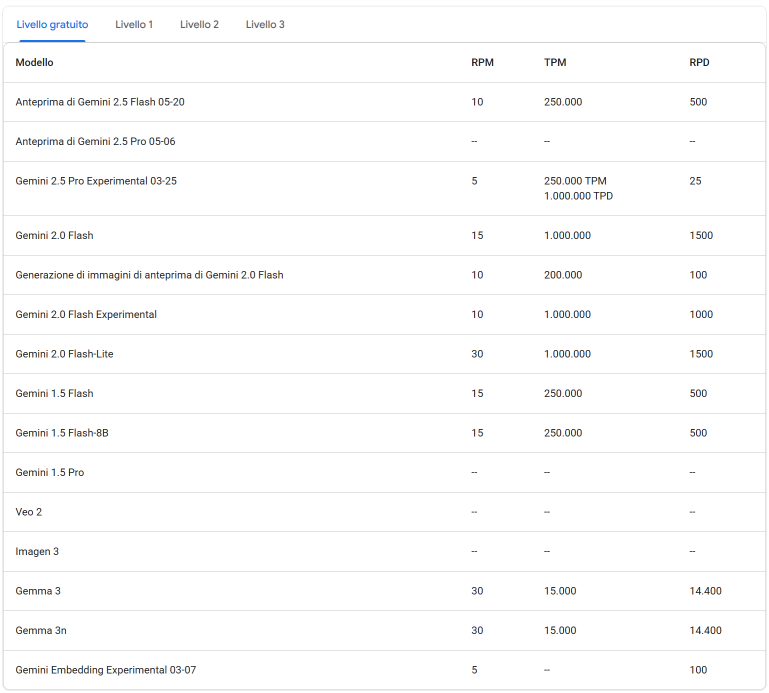

In [20]:
# Get the API key from the environment of Google Colab (a.k.a Secrets)
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
client = genai.Client(api_key=GOOGLE_API_KEY)

In [21]:
# Model loop
model_list = ["gemini-2.0-flash", "gemini-2.0-flash-lite", "gemma-3-4b-it", "gemma-3-27b-it"]
model_result = []

for model in model_list:
  print("---------------------\nTesting model `" + model + "`")
  # Call to the prompt 1

  values = prompt_1(model, dataset_sentences_array, wordpair_sentence_label)
  precision, recall, f1 = evaluation(values[0], values[1], values[2])

  # Add the results to the model_result array
  model_result.append(precision)
  model_result.append(recall)
  model_result.append(f1)

  # Print out the score
  print("Results for prompt 1: ")
  print("Recall: ", recall)
  print("Precision: ", precision)
  print("F1: ", f1)

  # Call to the prompt 2

  tp, fp, fn = prompt_2(model, dataset_sentences_array, wordpair_sentence_label)
  precision, recall, f1 = evaluation(tp, fp, fn)

  # Add the results to the model_result array
  model_result.append(precision)
  model_result.append(recall)
  model_result.append(f1)

  # Print out the score
  print("Results for prompt 2: ")
  print("Recall: ", recall)
  print("Precision: ", precision)
  print("F1: ", f1)

  # Call to the prompt 3

  tp, fp, fn = prompt_3(model, dataset_sentences_array, wordpair_sentence_label)
  precision, recall, f1 = evaluation(tp, fp, fn)

  # Add the results to the model_result array
  model_result.append(precision)
  model_result.append(recall)
  model_result.append(f1)

  # Print out the score
  print("Results for prompt 3: ")
  print("Recall: ", recall)
  print("Precision: ", precision)
  print("F1: ", f1)

  # Call to the prompt 4

  tp, fp, fn = prompt_4(model, dataset_sentences_array, wordpair_sentence_label)
  precision, recall, f1 = evaluation(tp, fp, fn)

  # Add the results to the model_result array
  model_result.append(precision)
  model_result.append(recall)
  model_result.append(f1)

  # Print out the score
  print("Results for prompt 4: ")
  print("Recall: ", recall)
  print("Precision: ", precision)
  print("F1: ", f1)

  print("---------------------\n")

---------------------
Testing model `gemini-2.0-flash`


100%|██████████| 30/30 [03:23<00:00,  6.79s/it]


Results for prompt 1: 
Recall:  0.8434
Precision:  0.9211
F1:  0.8805


100%|██████████| 30/30 [03:24<00:00,  6.80s/it]


Results for prompt 2: 
Recall:  0.744
Precision:  0.8562
F1:  0.7962


100%|██████████| 30/30 [03:24<00:00,  6.81s/it]


Results for prompt 3: 
Recall:  0.8817
Precision:  0.8976
F1:  0.8896


100%|██████████| 30/30 [03:24<00:00,  6.81s/it]


Results for prompt 4: 
Recall:  0.8988
Precision:  0.9096
F1:  0.9042
---------------------

---------------------
Testing model `gemini-2.0-flash-lite`


100%|██████████| 30/30 [03:20<00:00,  6.70s/it]


Results for prompt 1: 
Recall:  0.8214
Precision:  0.9388
F1:  0.8762


100%|██████████| 30/30 [03:21<00:00,  6.71s/it]


Results for prompt 2: 
Recall:  0.6988
Precision:  0.7733
F1:  0.7342


100%|██████████| 30/30 [03:20<00:00,  6.68s/it]


Results for prompt 3: 
Recall:  0.8155
Precision:  0.8839
F1:  0.8483


100%|██████████| 30/30 [03:20<00:00,  6.68s/it]


Results for prompt 4: 
Recall:  0.7964
Precision:  0.9301
F1:  0.8581
---------------------

---------------------
Testing model `gemma-3-4b-it`


100%|██████████| 30/30 [03:39<00:00,  7.31s/it]


Results for prompt 1: 
Recall:  0.5417
Precision:  0.6594
F1:  0.5948


100%|██████████| 30/30 [03:41<00:00,  7.38s/it]


Results for prompt 2: 
Recall:  0.3988
Precision:  0.4926
F1:  0.4408


100%|██████████| 30/30 [03:42<00:00,  7.40s/it]


Results for prompt 3: 
Recall:  0.5536
Precision:  0.6458
F1:  0.5962


100%|██████████| 30/30 [03:43<00:00,  7.46s/it]


Results for prompt 4: 
Recall:  0.6607
Precision:  0.6
F1:  0.6289
---------------------

---------------------
Testing model `gemma-3-27b-it`


100%|██████████| 30/30 [03:47<00:00,  7.60s/it]


Results for prompt 1: 
Recall:  0.8225
Precision:  0.8854
F1:  0.8528


100%|██████████| 30/30 [03:47<00:00,  7.57s/it]


Results for prompt 2: 
Recall:  0.7278
Precision:  0.8255
F1:  0.7736


 97%|█████████▋| 29/30 [03:58<00:08,  8.21s/it]


Results for prompt 3: 
Recall:  0.8272
Precision:  0.8645
F1:  0.8454


100%|██████████| 30/30 [03:48<00:00,  7.60s/it]

Results for prompt 4: 
Recall:  0.7904
Precision:  0.8684
F1:  0.8276
---------------------



## **3 - Analysis of Results**

This section provides a comprehensive analysis of the **zero-shot Named Entity Recognition (NER)** results. The discussion is structured in two parts. First, we examine the impact of the different prompting strategies on the performance of each individual model, highlighting the unique pros and cons of each approach. We then present a cross-model comparison for each prompt, evaluating their relative capabilities based on key metrics: *precision*, *recall*, and *F1-score*.

In [22]:
import matplotlib.pyplot as plt

# Set the figure size
plt.rcParams["figure.figsize"] = (13, 10)

In [23]:
y_precision = np.array([])
y_recall = np.array([])
y_f1_score = np.array([])

for i in range (0, len(model_result), 3):
  y_precision = np.append(y_precision, model_result[i])
  y_recall = np.append(y_recall, model_result[i + 1])
  y_f1_score = np.append(y_f1_score, model_result[i + 2])

### 3.1 - Analysis of the **`gemini-2.0-flash`** model

For the `gemini-2.0-flash` model, our analysis reveals distinct impacts from the various prompting strategies:

- **Baseline Performance (`prompt_1`):** The model performs strongly with the basic instructions, achieving a high value of F1-score, demonstrating a robust inherent zero-shot capability. It also exhibits the **highest precision among all prompts for this model**.
- **Impact of POS Tagging (`prompt_2`):** Surprisingly, providing **Part-of-Speech** (POS) tags significantly detrimentally impacts performance, causing the **F1-score** to **drop notably**. **Both** recall and precision decrease, suggesting that this form of linguistic augmentation might introduce noise or interfere with the model's internal parsing mechanisms.
- **AI-Generated Tips (`prompt_3`):** The AI-generated tips lead to a **slight decrease** in **F1-score** compared to the baseline. While recall is marginally improved, precision drops, indicating a trade-off where the model might become **slightly more aggressive** in tagging, potentially due to the nature of the generated tips.
- **Step-by-Step Guide (`prompt_4`):** This strategy proves to be **the most effective** for `gemini-2.0-flash`, **boosting** the **F1-score**. It achieves the **highest recall** and maintains **high precision**, demonstrating that highly structured, detailed operational guidance can significantly enhance the model's zero-shot NER capabilities.

In conclusion, `gemini-2.0-flash` benefits most from explicit, step-by-step instructions, while external POS tagging proves counterproductive for this model.

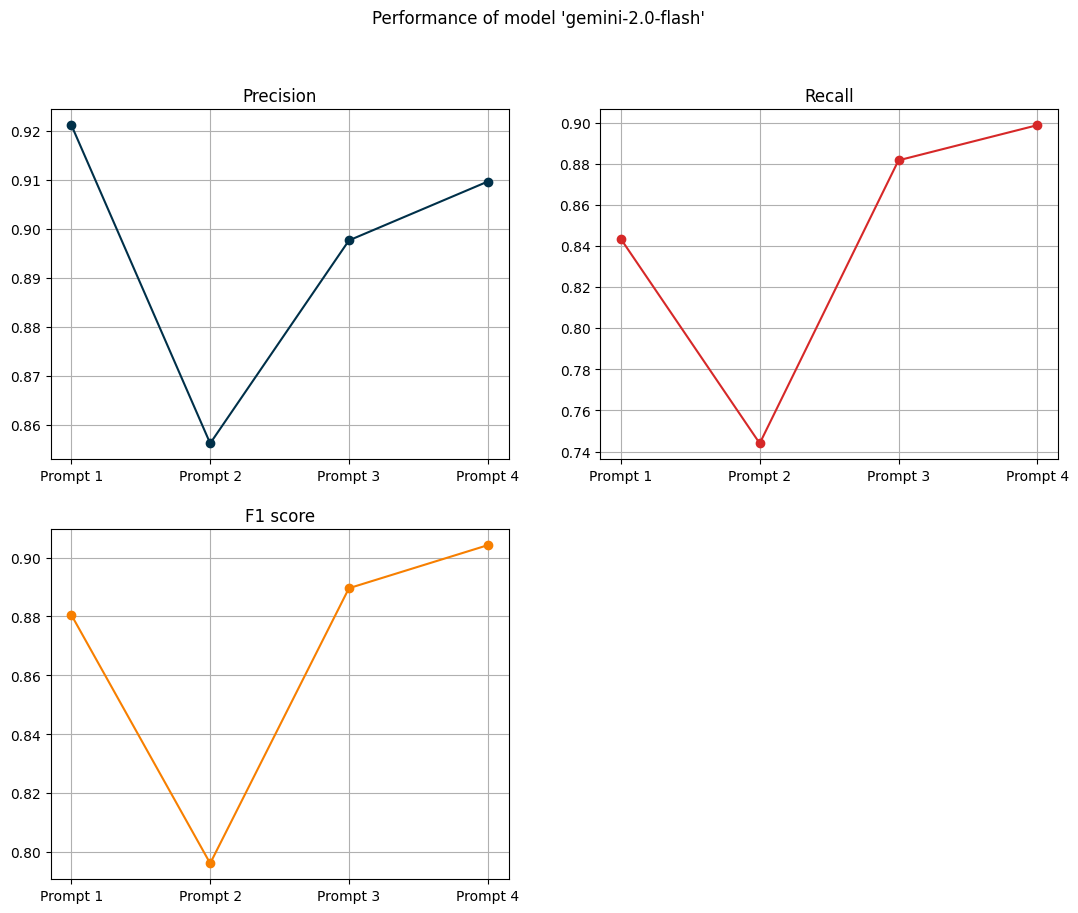

In [24]:
x = np.array(["Prompt 1","Prompt 2","Prompt 3", "Prompt 4"])

plt.subplot(2, 2, 1)
y = np.array(y_precision[0:4])
plt.title("Precision")
plt.plot(x,y, color='#003049', marker = 'o')
plt.grid()

plt.subplot(2, 2, 2)
y = np.array(y_recall[0:4])
plt.title("Recall")
plt.plot(x,y, color='#d62828', marker = 'o')
plt.grid()

plt.subplot(2, 2, 3)
y = np.array(y_f1_score[0:4])
plt.title("F1 score")
plt.plot(x,y, color='#f77f00', marker = 'o')
plt.grid()

plt.suptitle("Performance of model 'gemini-2.0-flash'")
plt.show()

### 3.2 - Analysis of the **`gemini-2.0-flash-lite`** model

The `gemini-2.0-flash-lite` model, being a lighter variant, exhibits a different sensitivity to prompting:

- **Baseline Dominance (`prompt_1`):** Unlike its larger counterpart, the flash-lite model **performs best** with the most straightforward baseline prompt, achieving a **notable F1-score**. This prompt also results in its **highest precision**.
- **Detrimental POS Tagging (`prompt_2`):** Similar to `gemini-2.0-flash`, the POS tagging prompt severely hinders performance, resulting in the **lowest F1-score** for this model. This suggests a consistent negative interaction with explicit POS features across the Gemini Flash family.
- **Reduced Performance with Tips (`prompt_3`):** Providing AI-generated tips leads to a **notable drop** in **F1-score** compared to the baseline, indicating these **tips do not improve performance** for this smaller model.
- **Step-by-Step Guide (`prompt_4`):** While `prompt_4` results in a higher F1 than `prompt_2` or `prompt_3`, it still falls short of the baseline's performance. This suggests that for `gemini-2.0-flash-lite`, simplicity and directness in prompting are more effective than added complexity.

Ultimately, the `gemini-2.0-flash-lite` model performs best when given concise, unaugmented instructions, showcasing a preference for less complex prompting in a zero-shot setting.

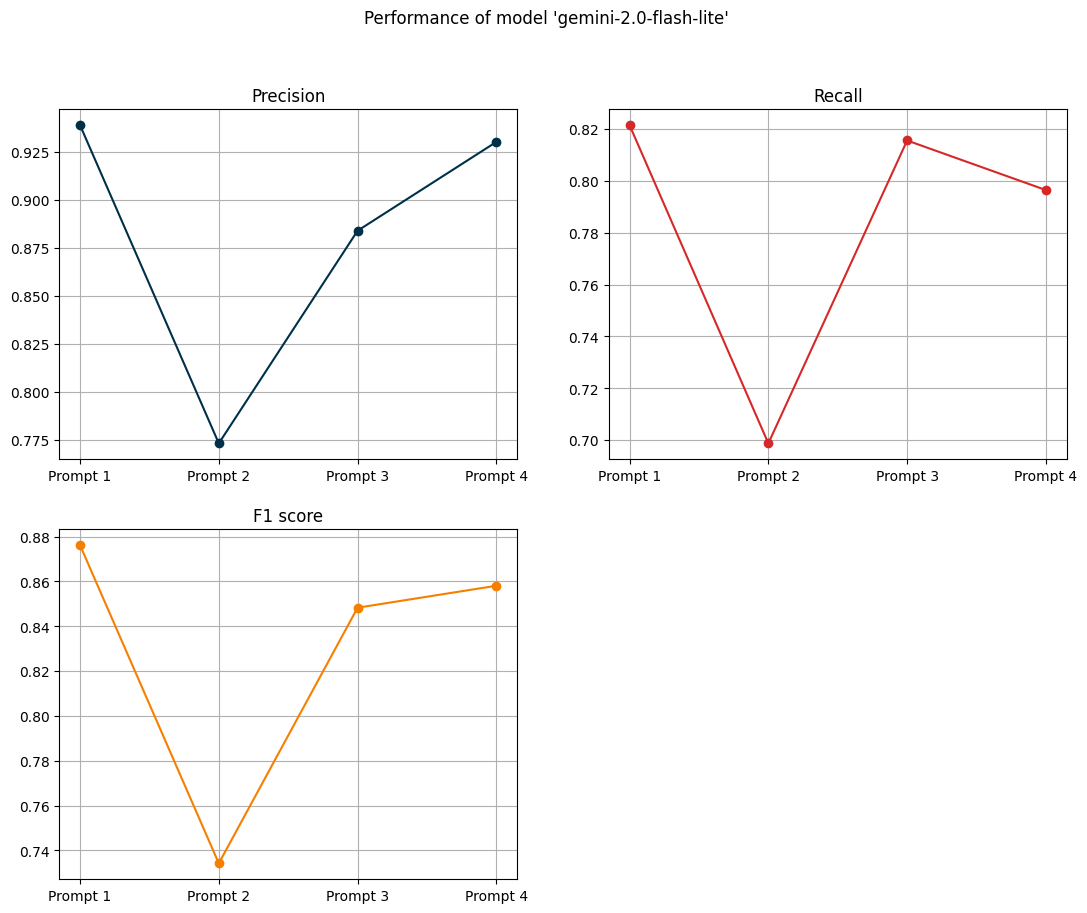

In [25]:
x = np.array(["Prompt 1","Prompt 2","Prompt 3", "Prompt 4"])

plt.subplot(2, 2, 1)
y = np.array(y_precision[4:8])
plt.title("Precision")
plt.plot(x,y, color='#003049', marker = 'o')
plt.grid()

plt.subplot(2, 2, 2)
y = np.array(y_recall[4:8])
plt.title("Recall")
plt.plot(x,y, color='#d62828', marker = 'o')
plt.grid()

plt.subplot(2, 2, 3)
y = np.array(y_f1_score[4:8])
plt.title("F1 score")
plt.plot(x,y, color='#f77f00', marker = 'o')
plt.grid()

plt.suptitle("Performance of model 'gemini-2.0-flash-lite'")
plt.show()

### 3.3 - Analysis of the **`gemma-3-4b-it`** model

The smallest Gemma model, `gemma-3-4b-it`, shows the most pronounced sensitivity to prompt engineering, particularly benefiting from structured guidance, despite being instruction-tuned primarily for Italian and receiving English input:

- **Baseline (`prompt_1`):** The model's baseline F1-score is decent, but still lower than Gemini models. However, this performance is noteworthy, considering the **cross-lingual zero-shot context** (Italian-tuned model processing English).
- **Significant Decline with POS Tagging (`prompt_2`):** POS tagging proves to be **highly detrimental**, causing the F1-score to plummet to its lowest point. This effect is even more pronounced given the language mismatch, as the model might struggle to reconcile its Italian-tuned understanding with externally provided English POS tags.
- **Marginal Gain with AI Tips (`prompt_3`):** The AI-generated tips offer only **a marginal improvement** over the baseline, resulting in an F1-score of closed to the one obtained with `prompt_1`.
- **Strong Improvement with Step-by-Step Guide (`prompt_4`):** The step-by-step guide is by far **the most effective strategy** for this model, dramatically boosting its F1-score. This is particularly significant as it demonstrates that even for a model operating in a **cross-lingual zero-shot scenario**, highly structured and didactic prompts can play a **crucial role** in improving its ability to understand and execute complex tasks.

In summary, `gemma-3-4b-it` benefits immensely from explicit, sequential instructions, indicating that prompt engineering can unlock capabilities even under challenging cross-lingual conditions.

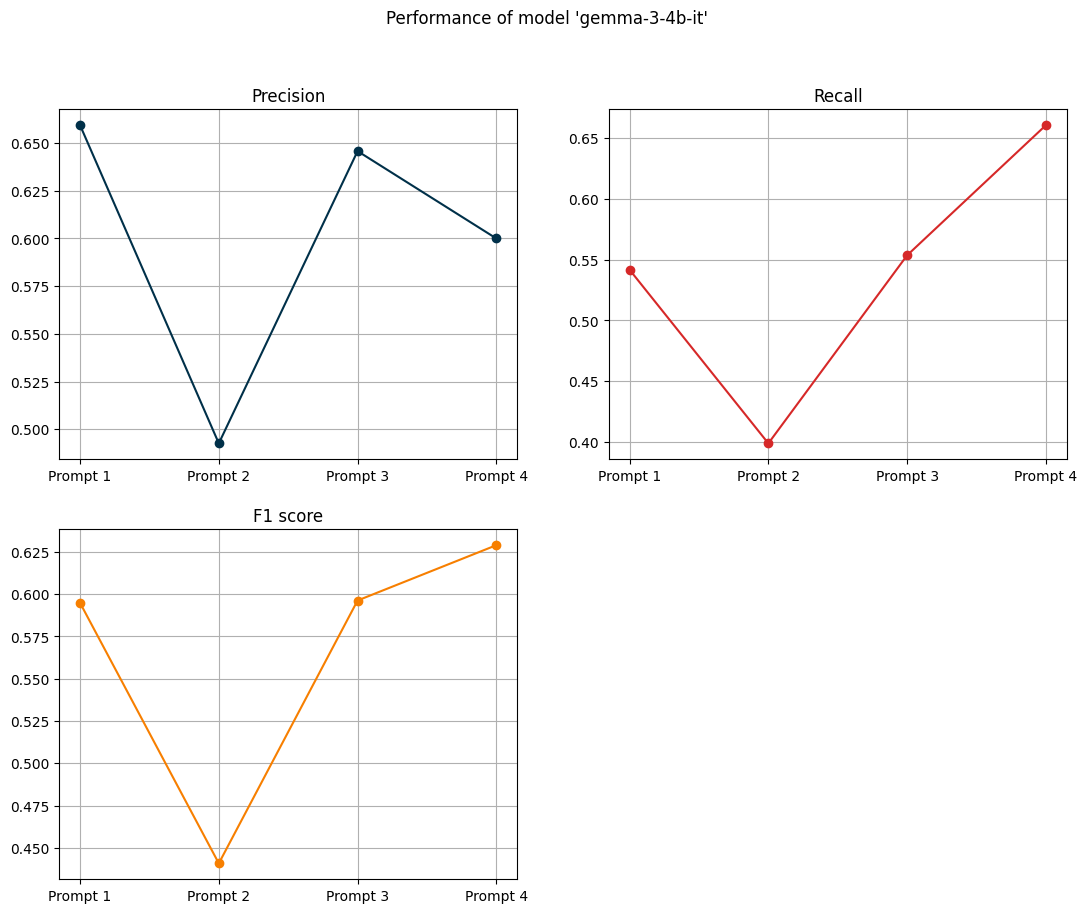

In [26]:
x = np.array(["Prompt 1","Prompt 2","Prompt 3", "Prompt 4"])

plt.subplot(2, 2, 1)
y = np.array(y_precision[8:12])
plt.title("Precision")
plt.plot(x,y, color='#003049', marker = 'o')
plt.grid()

plt.subplot(2, 2, 2)
y = np.array(y_recall[8:12])
plt.title("Recall")
plt.plot(x,y, color='#d62828', marker = 'o')
plt.grid()

plt.subplot(2, 2, 3)
y = np.array(y_f1_score[8:12])
plt.title("F1 score")
plt.plot(x,y, color='#f77f00', marker = 'o')
plt.grid()

plt.suptitle("Performance of model 'gemma-3-4b-it'")
plt.show()

### 3.4 - Analysis of the **`gemma-3-27b-it`** model

The larger `gemma-3-27b-it` model shows strong baseline performance, even when performing cross-lingual zero-shot NER from English to its Italian-tuned knowledge base, but also exhibits distinct responses to the various prompts:

- **Robust Baseline (`prompt_1`):** The model performs very well with the standard prompt, achieving an considerable F1-score. This is a highly commendable result for a model performing zero-shot NER in a language it wasn't primarily tuned for, showcasing **strong cross-lingual** transfer capabilities.
- **Negative Impact of POS Tagging (`prompt_2`):** Consistent with all other models, introducing POS tags **significantly degrades performance**, leading to an lower F1-score value. This reinforces the observation of a universal incompatibility or negative interaction of this specific POS augmentation method with the models tested, which might be exacerbated by the cross-lingual context.
- **Best Performance with AI Tips (`prompt_3`):** For `gemma-3-27b-it`, the AI-generated tips (`prompt_3`) provide the **best performance**, in terms of F1-score, **slightly** outperforming the baseline. This suggests that for powerful cross-lingual models, subtle, indirectly generated contextual cues can further refine output without over-constraining the model.
- **Reduced Performance with Step-by-Step Guide (`prompt_4`):** Unlike `gemini-2.0-flash` and `gemma-3-4b-it`, providing a detailed step-by-step guide actually leads to a **slight decrease** in performance compared to the baseline, resulting in the second top most F1-score value. This suggests that for more capable models, especially when **operating cross-lingually**, overly prescriptive instructions may not be necessary or might even interfere with their more flexible reasoning abilities trained on diverse data.

Overall, `gemma-3-27b-it` demonstrates excellent cross-lingual zero-shot NER capability. It benefits slightly from AI-generated tips but experiences a notable decline when presented with POS tags or an overly detailed step-by-step process.

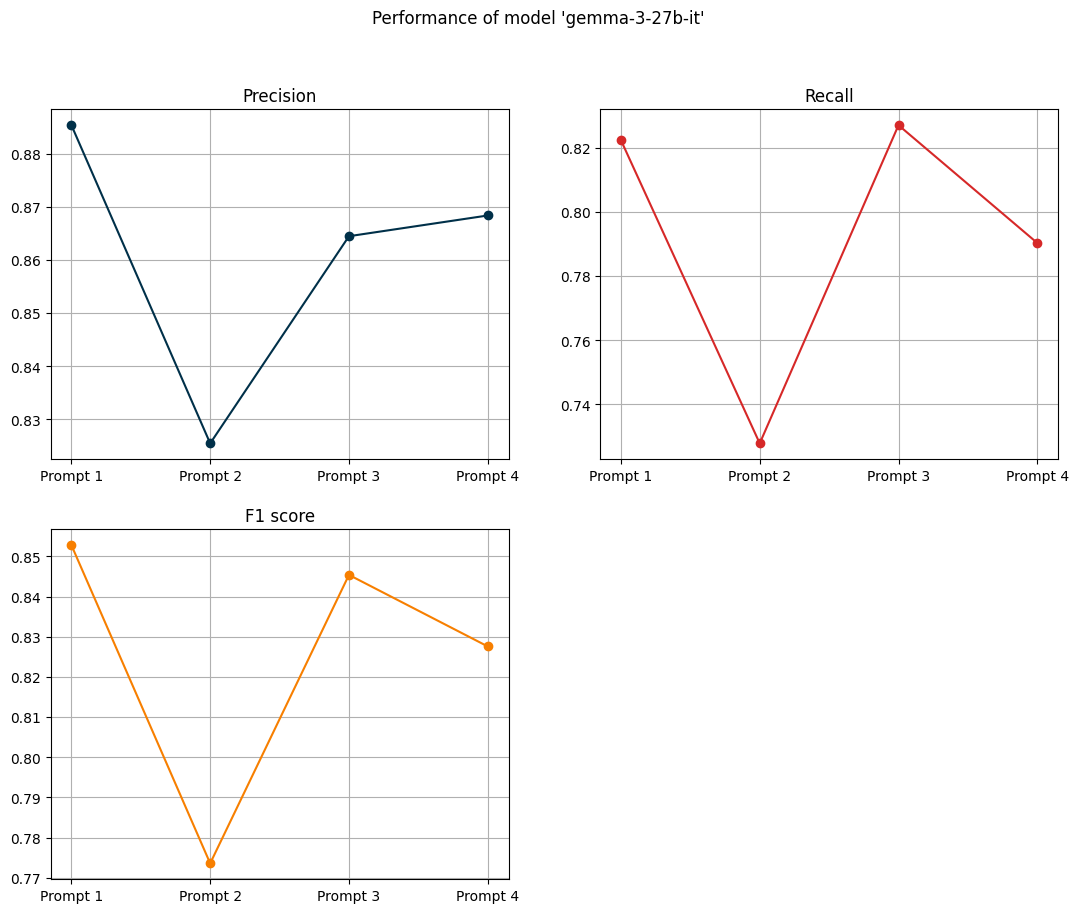

In [27]:
x = np.array(["Prompt 1","Prompt 2","Prompt 3", "Prompt 4"])

plt.subplot(2, 2, 1)
y = np.array(y_precision[12:])
plt.title("Precision")
plt.plot(x,y, color='#003049', marker = 'o')
plt.grid()

plt.subplot(2, 2, 2)
y = np.array(y_recall[12:])
plt.title("Recall")
plt.plot(x,y, color='#d62828', marker = 'o')
plt.grid()

plt.subplot(2, 2, 3)
y = np.array(y_f1_score[12:])
plt.title("F1 score")
plt.plot(x,y, color='#f77f00', marker = 'o')
plt.grid()

plt.suptitle("Performance of model 'gemma-3-27b-it'")
plt.show()

### 3.5 - Comparison between models

This section provides a comprehensive textual comparison of **all** four models' performance across **each individual prompting strategy**. This allows for a detailed understanding of which models prove most effective under specific instructional guidance, while also highlighting the impact of architectural differences and the crucial cross-lingual factor for the Gemma models.

#### 3.5.1 Comparison for `prompt_1` (Baseline Prompt)

When examining the baseline prompt, which offered only essential instructions, a clear hierarchy of performance emerged. The **Gemini models** demonstrated strong initial capabilities for English NER. `gemini-2.0-flash` achieved a **robust F1-score**, coupled with the **highest precision** among all models for this prompt. Its lighter counterpart, `gemini-2.0-flash-lite`, performed **remarkably close** with an F1-score, and notably boasted the **highest precision across all models** and prompts, suggesting an extremely conservative and accurate tagging approach.

However, the performance of the **Gemma models** in this baseline scenario is particularly insightful due to their **Italian instruction-tuning**. The `gemma-3-27b-it` model delivered an impressive F1-score, closed to Gemini models. This result is highly commendable given that it was performing zero-shot NER in English, a language it was **not** primarily tuned for, thus showcasing significant cross-lingual transfer capabilities. In stark contrast, the smaller `gemma-3-4b-it` model **struggled more**, yielding the lowest F1-score. This highlights the combined challenges of limited model size and the inherent difficulty of cross-lingual zero-shot learning without explicit adaptation.

#### 3.5.2 - Comparison for `prompt_2` (Prompt with Part-of-Speech Tagging)

The introduction of **Part-of-Speech** (POS) tags via `prompt_2` had a **universally and significantly detrimental effect** across all models, establishing itself as the least effective prompting strategy. `gemini-2.0-flash` saw a notable drop in its F1-score, while `gemini-2.0-flash-lite` experienced an even more substantial decline relative to its baseline, concerning to the F1-score. For the **Gemma models**, the impact was similarly negative. `gemma-3-27b-it`'s F1-score fell, while `gemma-3-4b-it` registered the lowest F1-score across all experiments. This consistent degradation across diverse models strongly suggests that integrating pre-calculated, explicit POS tags in the word/tag format interferes with the LLMs' internal tokenization, parsing, or their pre-learned implicit linguistic representations, essentially introducing noise rather than helpful signal for the NER task. This effect might be even more pronounced for the Italian-tuned Gemma models, as the English POS tags could clash with their primary linguistic understanding.

#### 3.5.3 - Comparison for `prompt_3` (Prompt with AI-Generated Tips)

The efficacy of incorporating AI-generated tips into the prompt (`prompt_3`) **varied considerably across the models**. For the **Gemini family**, the tips proved to be **less beneficial** than the baseline. `gemini-2.0-flash` saw a slight decrease in its F1-score, and `gemini-2.0-flash-lite` experienced a more noticeable drop compared to their respective baselines. This suggests that for these models, the automatically generated tips did not provide a **consistent advantage** or may have even introduced **subtle confusions**.

Conversely, the **Gemma models** showed some **positive response** to these tips. `gemma-3-4b-it` achieved a **marginal improvement** over its baseline, but a more significantly one comes from `gemma-3-27b-it`, which reached its **highest** F1-score with this prompt, slightly surpassing its baseline performance. This indicates that for larger, cross-lingual models, subtle, high-level tips can offer a beneficial refinement to their output without over-constraining their complex reasoning processes.

#### 3.5.4 - Comparison for `prompt_4` (Prompt with Step-by-Step Guide)

The step-by-step guide provided in `prompt_4` yielded **diverse and impactful results**, particularly highlighting its utility for certain model types. For `gemini-2.0-flash`, this prompt was the undisputed champion, boosting its F1-score to an impressive level ‒ **the highest overall F1-score achieved in the entire experiment**. This demonstrates the model's ability to significantly leverage highly structured, didactic guidance to optimize its zero-shot NER performance.

Similarly, for the smaller `gemma-3-4b-it` model, the step-by-step guide provided the most substantial improvement, **dramatically increasing its F1-score**. This is particularly significant given the model's size and cross-lingual challenge, illustrating that breaking down complex tasks into sequential steps can be crucial for enhancing understanding and execution in less capable models. It is worth noting that for this model, recall was higher than precision with this prompt, suggesting a more aggressive tagging approach.

However, the `gemini-2.0-flash-lite` model, while still performing reasonably, did not surpass its baseline performance with this prompt, and maintained **high precision at the expense of recall**. More surprisingly, the powerful `gemma-3-27b-it` model actually saw a **decrease in its F1-score** with the step-by-step guide compared to its baseline and `prompt_3`. This suggests that for highly capable models, especially those with strong cross-lingual abilities, overly explicit or prescriptive instructions might occasionally interfere with their intrinsic, efficient reasoning processes, rather than enhancing them.

In [28]:
y_f1_prompt_1 = np.array([])
y_f1_prompt_2 = np.array([])
y_f1_prompt_3 = np.array([])
y_f1_prompt_4 = np.array([])

for i in range (0, len(y_f1_score), 4):
  y_f1_prompt_1 = np.append(y_f1_prompt_1, y_f1_score[i])
  y_f1_prompt_2 = np.append(y_f1_prompt_2, y_f1_score[i + 1])
  y_f1_prompt_3 = np.append(y_f1_prompt_3, y_f1_score[i + 2])
  y_f1_prompt_4 = np.append(y_f1_prompt_4, y_f1_score[i + 3])

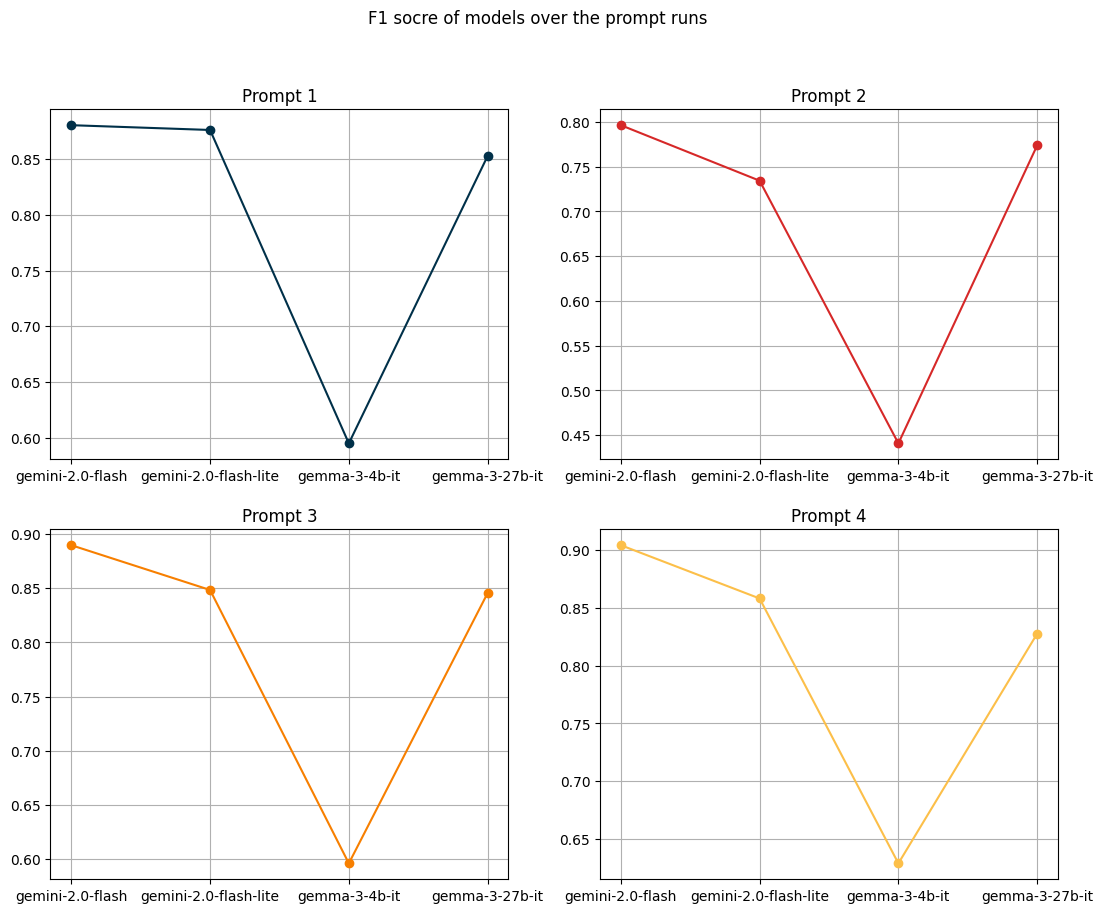

In [29]:
x = np.array(["gemini-2.0-flash", "gemini-2.0-flash-lite", "gemma-3-4b-it", "gemma-3-27b-it"])

plt.subplot(2, 2, 1)
plt.title("Prompt 1")
plt.plot(x,y_f1_prompt_1, color='#003049', marker = 'o')
plt.grid()

plt.subplot(2, 2, 2)
plt.title("Prompt 2")
plt.plot(x,y_f1_prompt_2, color='#d62828', marker = 'o')
plt.grid()

plt.subplot(2, 2, 3)
plt.title("Prompt 3")
plt.plot(x,y_f1_prompt_3, color='#f77f00', marker = 'o')
plt.grid()

plt.subplot(2, 2, 4)
plt.title("Prompt 4")
plt.plot(x,y_f1_prompt_4, color='#fcbf49', marker = 'o')
plt.grid()

plt.suptitle("F1 socre of models over the prompt runs")
plt.show()

## **Conclusion**


This project investigated the effectiveness of various prompting strategies on Google Gemini models (`gemini-2.0-flash`, `gemini-2.0-flash-lite`, `gemma-3-4b-it`, `gemma-3-27b-it`) for zero-shot Named Entity Recognition (NER) on a subset of the CoNLL-2003 dataset. The evaluation focused exclusively on non-'O' (non-entity) tags to provide a more targeted assessment of the models' ability to identify relevant entities, mitigating the impact of class imbalance.

The results, as indicated by the F1-scores, reveal significant differences in performance across the models and prompting strategies:

- `gemini-2.0-flash` emerged as the best-performing model overall, achieving the highest F1-score of **0.9042** with **Prompt 4 (Step-by-Step Guide)**. This model consistently demonstrated strong performance across all prompts, suggesting its inherent capability for NER tasks.

- **Prompt 4 (Step-by-Step Guide)** consistently yielded the best results across all models (average F1-score of **0.796**). This highlights the critical role of structured, explicit instructions in guiding LLMs to perform complex tasks like NER in a zero-shot setting. Providing a clear, logical breakdown of the task significantly improved the models' ability to correctly identify and classify named entities.

- **Prompt 3 (AI-Generated Tips)** also showed promising results, particularly with `gemini-2.0-flash` (F1-score: 0.8896), securing the second-best performance. This indicates that dynamically generated, context-aware tips can be highly beneficial in enhancing the models' zero-shot NER capabilities.

- **Prompt 2 (Part-of-Speech Tagging)**, while providing syntactic information, did not consistently outperform the simpler baseline or the more guided prompts. Its performance varied, suggesting that while POS tags can be helpful, their impact is less pronounced than explicit step-by-step guidance or AI-generated tips for zero-shot NER.

- **Prompt 1 (Baseline)** generally exhibited the lowest performance, confirming that straightforward zero-shot prompting without additional guidance is less effective for NER with these models. This underscores the necessity of well-crafted prompts to unlock the full potential of LLMs in specialized tasks.

In summary, for zero-shot NER on the CoNLL-2003 dataset, `gemini-2.0-flash` coupled with a **Step-by-Step Guide (Prompt 4)** proved to be the most effective combination. The study demonstrates that carefully designed prompting strategies, especially those providing structured guidance, can substantially enhance the performance of LLMs in zero-shot learning environments, making them viable tools for tasks like Named Entity Recognition even without extensive fine-tuning.